In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import eddytools as et
from cmocean import cm
from scipy.signal import convolve
import os
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
# Obviously it is not a great idea to ignore warnings, however there are quite many
# RuntimeWarnings because of division by 0 in some parts of this notebook. To keep
# the instructive nature of this example notebook, these warnings are ignored.

In [2]:
experiment_name = 'INALT60.L120-KRS0020'
data_resolution = '1d'

sigma = 1 # smoothing parameter
wx = int(100*15) # rolling window size in x-direction
wy = int(100*15) # rolling window size in y-direction

In [3]:
# Define the parameters for the interpolation
interpolation_parameters = {'model': 'ORCA',
                            'grid': 'latlon',
                            'calendar': 'standard', # calendar, must be either 360_day or standard
                            'lon1': 0, # minimum longitude of detection region
                            'lon2': 40, # maximum longitude
                            'lat1': -45, # minimum latitude
                            'lat2': -25, # maximum latitude
                            'res': 1./60., # resolution of the fields in degrees
                            'vars_to_interpolate': ['OW', 'vort'], # variables to be interpolated #, 'votemper', 'vosaline'
                            'mask_to_interpolate': ['fmask', 'tmask', 'bathymetry'], # masks to interpolate
                            'regrid_method': 'bilinear', # method used for regridding (default is 'bilinear')
                            'ext_method': None} 

In [4]:
datestart, dateend = "2012-04-10", "2012-05-04"
#periods = [
#    #("2012-01-01", "2012-01-25"), ("2012-01-26", "2012-02-19"), ("2012-02-20", "2012-03-15"), ("2012-03-16", "2012-04-09"),
#    ("2012-04-10", "2012-05-04"), ("2012-05-05", "2012-05-29"),
#    ("2012-05-30", "2012-06-28"), ("2012-10-27", "2012-11-20"), ("2012-11-21", "2012-12-15"),
#    
#    ("2012-06-29", "2012-07-28"), ("2012-07-29", "2012-08-27"), ("2012-08-28", "2012-09-26"), ("2012-09-27", "2012-10-26"),
#]

In [ ]:
if experiment_name.startswith("INALT60"):
    prefix = "2_"
    interpolation_parameters['res'] = 1./60.
    interpolation_parameters['lon1'], interpolation_parameters['lon2'] = 0, 40
    interpolation_parameters['lat1'], interpolation_parameters['lat2'] = -45, -25
elif experiment_name.startswith("INALT20"):
    prefix = "1_"
    interpolation_parameters['res'] = 1./20.
    interpolation_parameters['lon1'], interpolation_parameters['lon2'] = -19, 40
    interpolation_parameters['lat1'], interpolation_parameters['lat2'] = -49, -7

In [ ]:
# paths

#'/gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/' + output or suppl
datapath = f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'                  ## !! SMOOTHED !!
meshpath = [datapath + f'{prefix}{experiment_name}_mesh_mask.nc']

In [5]:
#depth= 0  #corresponding to... 
#depth_index = 0 

mesh_mask = xr.open_dataset(meshpath[0]) 
indices = np.concatenate((range(0, 11, 10),range(18, 25, 6),range(29, 34, 4),range(36, 40, 3),range(41, 120, 2)))
depth_information = [(round(mesh_mask.nav_lev.values[i]), i) for i in indices]
print(len(depth_information),depth_information)

48 [(0, 0), (21, 10), (54, 18), (91, 24), (132, 29), (173, 33), (210, 36), (253, 39), (286, 41), (323, 43), (365, 45), (412, 47), (465, 49), (525, 51), (592, 53), (668, 55), (753, 57), (848, 59), (952, 61), (1066, 63), (1189, 65), (1321, 67), (1461, 69), (1608, 71), (1762, 73), (1922, 75), (2086, 77), (2255, 79), (2428, 81), (2603, 83), (2782, 85), (2963, 87), (3146, 89), (3331, 91), (3518, 93), (3706, 95), (3896, 97), (4086, 99), (4279, 101), (4472, 103), (4666, 105), (4861, 107), (5057, 109), (5254, 111), (5452, 113), (5651, 115), (5850, 117), (6050, 119)]


In [7]:
def nanconv(a, k, MODE):
    # Flat function for comparison.
    o = np.ones(np.shape(a))
    # Flat function with NaNs for comparison.
    on = np.ones(np.shape(a))
    # Find all the NaNs in the input and replace with 0
    an = np.where(~np.isnan(a), a, 0)
    on = np.where(~np.isnan(a), on, 0)
    # Calculate what a 'flat' function looks like after convolution.
    flat = convolve(on, k, mode=MODE)
    #
    # The line above will automatically include a correction for edge 
    # effects,
    # so remove that correction if the user does not want it.
    flat = flat / convolve(o, k, mode=MODE)
    #
    # Do the actual convolution
    output = convolve(an, k, mode=MODE) / flat
    return np.where(~np.isnan(a), output, np.nan)

def spatial_std(data, wx, wy):
    window = np.ones((1, wy, wx)) / (wy * wx)
    ext = np.zeros((np.shape(data)[0], 
                    np.shape(data)[1] + wy, np.shape(data)[2] + wx))
    ext[:, int(wy/2):-int(wy/2), int(wx/2):-int(wx/2)] = data
    ext[:, 0:int(wy/2), :] = ext[:, int(wy):int(wy/2):-1, :]
    ext[:, -int(wy/2)::, :] = ext[:, -int(wy/2):-int(wy):-1, :]
    ext[:, :, 0:int(wx/2)] = ext[:, :, int(wx):int(wx/2):-1]
    ext[:, :, -int(wx/2)::] = ext[:, :, -int(wx/2):-int(wx):-1]
    std_tmp1 = np.abs(ext - nanconv(ext, window, "same")) ** 2
    std_tmp2 = nanconv(std_tmp1, window, "same") ** 0.5
    output =  xr.DataArray(std_tmp2[:, int(wy/2):-int(wy/2), int(wx/2):-int(wx/2)], 
                           coords=data.coords, dims=data.dims).mean("time") 
    return output

In [ ]:
#for (datestart, dateend) in tqdm(periods):
#    print(f"> Starting: {datestart.replace("-", "")}-{dateend.replace("-", "")} ...")
for (depth, depth_index) in tqdm(depth_information):
    print(f"> Starting: {datestart.replace('-', '')}, {depth}m ...")
    interpolation_parameters['start_time'], interpolation_parameters['end_time'] = datestart, dateend
    if sigma == 1:
        filename_pattern = f'{prefix}{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_grid_[UV].nc'
    else:
        filename_pattern = f'{prefix}{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_[UV].nc' ## !! SMOOTHED !!
    data_in = sorted(glob(datapath + filename_pattern))
    outpath = f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/depth-{depth}/'   ## !! SMOOTHED !!
    os.makedirs(outpath, exist_ok=True)
    output_file = os.path.join(outpath, f'OW_{datestart.replace("-", "")}_{dateend.replace("-", "")}_rolling-{wx}.nc')
    if os.path.exists(output_file):
        print(f"File {output_file} already exists. Skipping...")
        continue

    if experiment_name.startswith("INALT60"):
        data = load_xorca_dataset(data_files=data_in, aux_files=meshpath, model_config='NEST',
                          input_ds_chunks = {"time_counter": 1, "depthu": 1, "depthv": 1, "depthw": 1, "t": 1, "z": 120, "x": 2404, "y": 1483},
                          target_ds_chunks = {"t": 1, "z_c": 1, "z_l": 1, "x_c": 2404, "x_r": 2404, "y_c": 1483, "y_r": 1483},
                          decode_cf=True,   
                         )
    elif experiment_name.startswith("INALT20"):
        data = load_xorca_dataset(data_files=data_in, aux_files=meshpath, model_config='NEST',
                          input_ds_chunks = {"time_counter": 1, "depthu": 1, "depthv": 1, "depthw": 1, "t": 1, "z": 120, "x": 1804, "y": 1024},
                          target_ds_chunks = {"t": 1, "z_c": 1, "z_l": 1, "x_c": 1804, "x_r": 1804, "y_c": 1024, "y_r": 1024},
                          decode_cf=True,   
                         )
    
    # define metrics for xgcm (not strictly necessary)
    at, au = data['e1t'] * data['e2t'], data['e1u'] * data['e2u']
    av, af = data['e1v'] * data['e2v'], data['e1f'] * data['e2f']
    vt, vu, vv, vw = data['e3t'] * at, data['e3u'] * au, data['e3v'] * av, data['e3w'] * at

    data = data.update({'at': at, 'au': au, 'av': av, 'af': af, 'vt': vt, 'vu': vu, 'vv': vv, 'vw': vw})
    data = data.set_coords(['at', 'au', 'av', 'af', 'vt', 'vu', 'vv', 'vw'])

    metrics = {
        ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
        ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
        ('X', 'Y'): ['at', 'au', 'av', 'af'], # Areas
        ('X', 'Y', 'Z'): ['vt', 'vu', 'vv', 'vw'] # Volumes
    }

    # add bathymetry to data to have depth information
    bathy = xr.open_dataset(f'/gxfs_work/geomar/smomw523/processed_data/{experiment_name}/{prefix}{experiment_name}_bathy.nc')
    data = data.update({'bathymetry': (['y_c', 'x_c'], bathy['bathymetry'].data)})

    grid = xgcm.Grid(data, metrics=metrics)

    # Calculate vorticity and Okubo-Weiss parameter and make sure the chunk sizes are as before.
    if experiment_name.startswith("INALT60"):
        data_OW = et.okuboweiss.calc(data.isel(z_c=depth_index, z_l=depth_index), grid, #surface
                                'vozocrtx', 'vomecrty').chunk({'x_c': 2404, 'x_r': 2404,
                                                                'y_c': 1483, 'y_r': 1483})
    elif experiment_name.startswith("INALT20"):
        data_OW = et.okuboweiss.calc(data.isel(z_c=depth_index, z_l=depth_index), grid, #surface
                                'vozocrtx', 'vomecrty').chunk({'x_c': 1804, 'x_r': 1804,
                                                                'y_c': 1024, 'y_r': 1024})
    # Merge the new variables `OW` and `vort` to the dataset `data`
    data = xr.merge([data, data_OW], compat='override')
    # Interpolate
    data_int, regridder = et.interp.horizontal(data, metrics, interpolation_parameters, weights=None, avoid_regrid=False)

    OW_tmp = data_int['OW'].compute()
    OW_tmp = OW_tmp.where(OW_tmp != 0)
    lon_tmp = OW_tmp['lon'].where(OW_tmp['lon'] > 0, other=OW_tmp['lon'] + 360.)
    OW_tmp = OW_tmp.assign_coords({'lon': lon_tmp})
    mean_OW_spatial_std = spatial_std(OW_tmp, wx, wy)
    # use if OW_std is 2D
    data_int = data_int.update({'OW_std': (['lat', 'lon'], mean_OW_spatial_std.values)})

     # Store the interpolated field on disk so we do not have to do the interpolation again
    data_int.to_netcdf(output_file)


  0%|          | 0/48 [00:00<?, ?it/s]

> Starting: 20120410, 0m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


  2%|▏         | 1/48 [02:24<1:53:23, 144.75s/it]

> Starting: 20120410, 21m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


  4%|▍         | 2/48 [04:46<1:49:39, 143.03s/it]

> Starting: 20120410, 54m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


  6%|▋         | 3/48 [07:06<1:46:03, 141.40s/it]

> Starting: 20120410, 91m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


  8%|▊         | 4/48 [09:24<1:42:50, 140.25s/it]

> Starting: 20120410, 132m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 10%|█         | 5/48 [11:42<1:39:50, 139.32s/it]

> Starting: 20120410, 173m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 12%|█▎        | 6/48 [14:01<1:37:30, 139.29s/it]

> Starting: 20120410, 210m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 15%|█▍        | 7/48 [16:14<1:33:45, 137.21s/it]

> Starting: 20120410, 253m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 17%|█▋        | 8/48 [18:33<1:31:50, 137.77s/it]

> Starting: 20120410, 286m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 19%|█▉        | 9/48 [20:51<1:29:34, 137.81s/it]

> Starting: 20120410, 323m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 21%|██        | 10/48 [23:10<1:27:30, 138.17s/it]

> Starting: 20120410, 365m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 23%|██▎       | 11/48 [25:23<1:24:12, 136.56s/it]

> Starting: 20120410, 412m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 25%|██▌       | 12/48 [27:37<1:21:27, 135.76s/it]

> Starting: 20120410, 465m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 27%|██▋       | 13/48 [29:52<1:19:04, 135.56s/it]

> Starting: 20120410, 525m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 29%|██▉       | 14/48 [32:07<1:16:44, 135.42s/it]

> Starting: 20120410, 592m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 31%|███▏      | 15/48 [34:22<1:14:29, 135.45s/it]

> Starting: 20120410, 668m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 33%|███▎      | 16/48 [36:41<1:12:45, 136.43s/it]

> Starting: 20120410, 753m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 35%|███▌      | 17/48 [38:57<1:10:23, 136.25s/it]

> Starting: 20120410, 848m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 38%|███▊      | 18/48 [41:13<1:08:04, 136.16s/it]

> Starting: 20120410, 952m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 40%|███▉      | 19/48 [43:22<1:04:44, 133.95s/it]

> Starting: 20120410, 1066m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 42%|████▏     | 20/48 [45:34<1:02:17, 133.47s/it]

> Starting: 20120410, 1189m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 44%|████▍     | 21/48 [47:42<59:16, 131.73s/it]  

> Starting: 20120410, 1321m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 46%|████▌     | 22/48 [50:00<57:56, 133.70s/it]

> Starting: 20120410, 1461m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 48%|████▊     | 23/48 [52:10<55:17, 132.70s/it]

> Starting: 20120410, 1608m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 50%|█████     | 24/48 [54:22<52:54, 132.29s/it]

> Starting: 20120410, 1762m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 52%|█████▏    | 25/48 [56:41<51:30, 134.35s/it]

> Starting: 20120410, 1922m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 54%|█████▍    | 26/48 [58:48<48:28, 132.19s/it]

> Starting: 20120410, 2086m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 56%|█████▋    | 27/48 [1:01:05<46:47, 133.71s/it]

> Starting: 20120410, 2255m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 58%|█████▊    | 28/48 [1:03:24<45:03, 135.19s/it]

> Starting: 20120410, 2428m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 60%|██████    | 29/48 [1:05:30<42:00, 132.65s/it]

> Starting: 20120410, 2603m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 62%|██████▎   | 30/48 [1:07:51<40:29, 134.96s/it]

> Starting: 20120410, 2782m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 65%|██████▍   | 31/48 [1:10:08<38:25, 135.61s/it]

> Starting: 20120410, 2963m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 67%|██████▋   | 32/48 [1:12:23<36:06, 135.38s/it]

> Starting: 20120410, 3146m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 69%|██████▉   | 33/48 [1:14:47<34:30, 138.04s/it]

> Starting: 20120410, 3331m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 71%|███████   | 34/48 [1:17:03<32:03, 137.40s/it]

> Starting: 20120410, 3518m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 73%|███████▎  | 35/48 [1:19:22<29:51, 137.80s/it]

> Starting: 20120410, 3706m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 75%|███████▌  | 36/48 [1:21:40<27:35, 137.95s/it]

> Starting: 20120410, 3896m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 77%|███████▋  | 37/48 [1:23:37<24:07, 131.57s/it]

> Starting: 20120410, 4086m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 79%|███████▉  | 38/48 [1:25:34<21:11, 127.20s/it]

> Starting: 20120410, 4279m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 81%|████████▏ | 39/48 [1:27:47<19:22, 129.19s/it]

> Starting: 20120410, 4472m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 83%|████████▎ | 40/48 [1:30:02<17:26, 130.85s/it]

> Starting: 20120410, 4666m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 85%|████████▌ | 41/48 [1:32:02<14:53, 127.60s/it]

> Starting: 20120410, 4861m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 88%|████████▊ | 42/48 [1:34:00<12:28, 124.72s/it]

> Starting: 20120410, 5057m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 90%|████████▉ | 43/48 [1:35:57<10:12, 122.40s/it]

> Starting: 20120410, 5254m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 92%|█████████▏| 44/48 [1:38:10<08:22, 125.61s/it]

> Starting: 20120410, 5452m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 94%|█████████▍| 45/48 [1:40:27<06:26, 128.90s/it]

> Starting: 20120410, 5651m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 96%|█████████▌| 46/48 [1:42:37<04:18, 129.30s/it]

> Starting: 20120410, 5850m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 98%|█████████▊| 47/48 [1:44:58<02:12, 132.67s/it]

> Starting: 20120410, 6050m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


100%|██████████| 48/48 [1:47:10<00:00, 133.97s/it]


### Visualisation

FileNotFoundError: [Errno 2] No such file or directory: b'/gxfs_work/geomar/smomw523/eddytools/results/INALT60.L120-KRS0020/smoothed/1/1d/depth-6050/OW_20120410_20120504.nc'

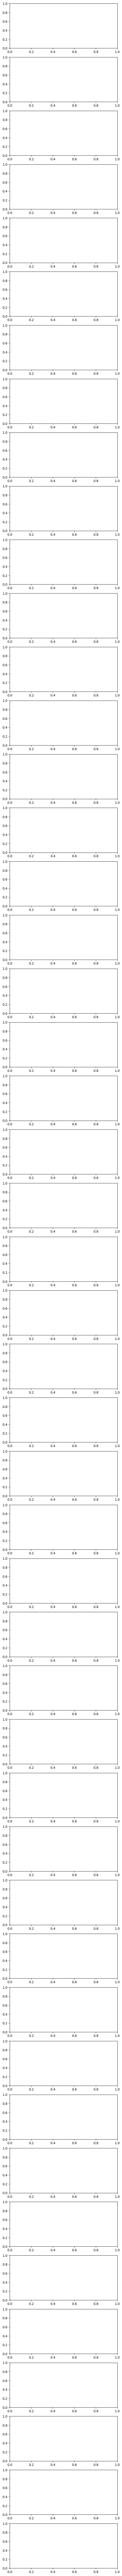

In [ ]:
#fig, axes = plt.subplots(len(periods), 1, figsize=(10, 5 * len(periods))) 
#for ax, (datestart, dateend) in zip(axes, periods):
fig, axes = plt.subplots(len(depth_information), 1, figsize=(6, 3 * len(depth_information))) 
for ax, (depth, depth_index) in zip(axes, depth_information):
    data_int = xr.open_dataset(outpath + f'OW_{datestart.replace("-", "")}_{dateend.replace("-", "")}_rolling-{wx}.nc')
    im = ax.pcolormesh(data_int['lon'].values,
                       data_int['lat'].values,
                       data_int['OW'].isel(time=0), vmin=-1e-9, vmax=1e-9, cmap=cm.balance)
    ax.set_title(f'OW {datestart.replace("-", "")}, {depth}m')
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

We see several eddy-like features that have a low OW-parameter, now let's see whether the algorithm detects them as eddies!